In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### Load the datasets

In [4]:
# get games
games = pd.read_csv('games_raw.csv')

# get teams
teams = pd.read_csv('teams.csv')

In [5]:
# merge teams to games
team_names = teams[['team_id', 'team']]
games = games.merge(team_names, on='team_id', how='left')
games.head()

,team_id,game,date_str,time,type,site,opp,conf,srs,team_result,team_pts,opp_pts,ot,win_num,loss_num,streak,arena,team
0,2,1,Thu Nov 9 2023,7:00p,REG,NaN,Eastern Illinois,OVC,-9.80,W,96.0,43.0,NaN,1.0,0.0,W 1,Simon Skjodt Assembly Hall,Indiana
1,2,2,Sun Nov 12 2023,5:00p,REG,@,Stanford (15),Pac-12,36.17,L,64.0,96.0,NaN,1.0,1.0,L 1,Maples Pavilion,Indiana
2,2,3,Fri Nov 17 2023,7:00p,REG,NaN,Murray State,MVC,7.04,W,112.0,79.0,NaN,2.0,1.0,W 1,Simon Skjodt Assembly Hall,Indiana
3,2,4,Sun Nov 19 2023,2:00p,REG,NaN,Lipscomb,A-Sun,-4.10,W,77.0,44.0,NaN,3.0,1.0,W 2,Simon Skjodt Assembly Hall,Indiana
4,2,5,Thu Nov 23 2023,6:00p,REG,N,Tennessee (19),SEC,23.24,W,71.0,57.0,NaN,4.0,1.0,W 3,Suncoast Credit Union Arena,Indiana


In [6]:
games.dtypes

team_id          int64
game             int64
date_str        object
time            object
type            object
site            object
opp             object
conf            object
srs            float64
team_result     object
team_pts       float64
opp_pts        float64
ot              object
win_num        float64
loss_num       float64
streak          object
arena           object
team            object
dtype: object

### Generate new columns for features

In [7]:
# create date
games['date'] = pd.to_datetime(games['date_str'])

# day of week
games['dow'] = games['date'].dt.weekday

# month
games['month'] = games['date'].dt.month

# day
games['day'] = games['date'].dt.day

# year
games['year'] = games['date'].dt.year

# site
games['site'] = games['site'].apply(lambda x: 0 if x == '@' else -1 if x == 'N' else 1)

# distance from home


# last game




### Clean data as needed

In [8]:
# na
games.isna().any()

team_id        False
game           False
date_str       False
time            True
type           False
site           False
opp             True
conf            True
srs             True
team_result     True
team_pts        True
opp_pts         True
ot              True
win_num         True
loss_num        True
streak          True
arena           True
team           False
date           False
dow            False
month          False
day            False
year           False
dtype: bool

In [9]:
# separate upcoming games
upcoming = games[games['team_result'].isna()]
played = games[games['team_result'].notna()]


played.to_csv('2023_games.csv')

print(upcoming.shape[0])
print(played.shape[0])

17
407


In [10]:
# update result column to binary
result_encoder = {'team_result': {'W': 1, 'L': 0}}

# encode result column using encoder
played.replace(result_encoder, inplace=True)

# check result value counts
played['team_result'].value_counts()

C:\Users\Geoff\AppData\Local\Temp\ipykernel_44140\3332228290.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  played.replace(result_encoder, inplace=True)


1    240
0    167
Name: team_result, dtype: int64

In [11]:
# fill na for this feature
played['srs'].fillna(0, inplace=True)


C:\Users\Geoff\AppData\Local\Temp\ipykernel_44140\3358791329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  played['srs'].fillna(0, inplace=True)


### Exploratory

In [12]:
team1 = played[played['team_id'] == 2]
team2 = played[played['team_id'] == 3]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

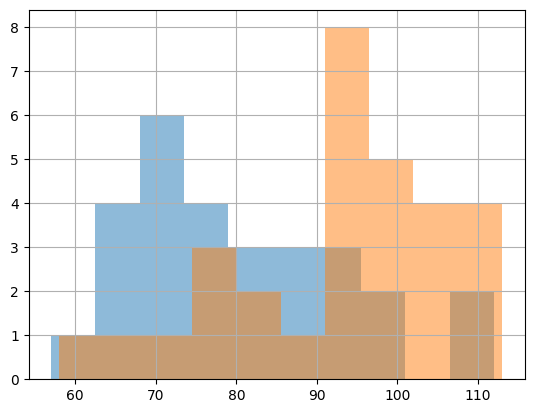

In [13]:
# hist of pts
team1['team_pts'].hist(alpha=0.5, bins=10)
team2['team_pts'].hist(alpha=0.5, bins=10)
plt.legend([team1['team'], team2['team']])
plt.show()

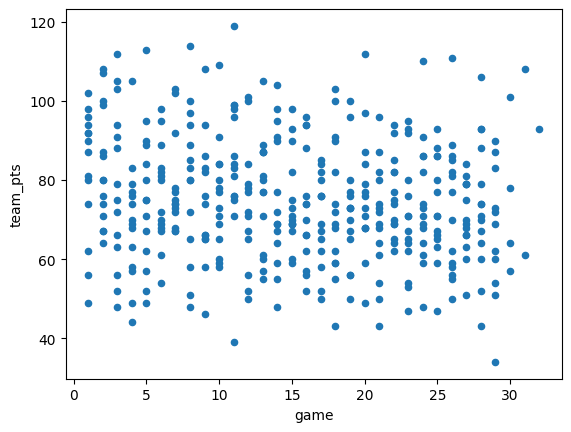

In [ ]:
# do teams score more over time?
played.plot(x='game', y='team_pts', kind='scatter')
plt.show()

                     mean         var        std
team                                            
Iowa            92.666667  187.264368  13.684457
Michigan State  84.482759  193.401478  13.906886
Penn State      84.448276  222.970443  14.932195
Ohio State      80.448276  108.399015  10.411485
Indiana         80.321429  191.929894  13.853877
Maryland        77.931034  177.923645  13.338802
Illinois        74.785714  199.433862  14.122105
Nebraska        73.000000  140.500000  11.853270
Minnesota       70.137931  284.980296  16.881359
Michigan        69.800000  186.648276  13.661928
Purdue          68.689655  166.150246  12.889928
Northwestern    65.931034  128.209360  11.322957
Rutgers         65.709677  142.612903  11.942064
Wisconsin       62.071429  102.661376  10.132195


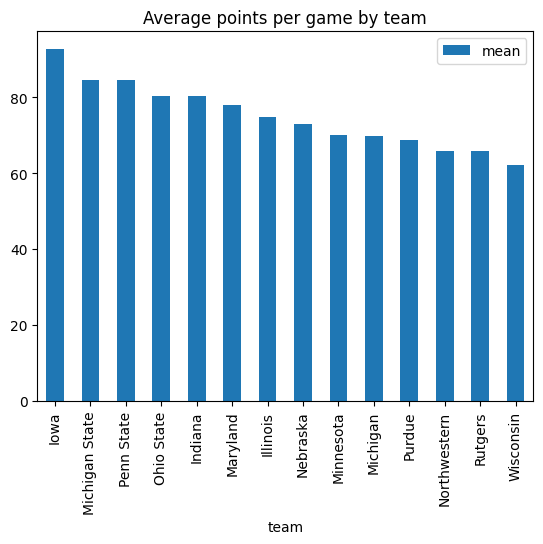

In [ ]:
# Which team averages the most points per game?
# aggregate team_points by team_id and then plot
team_stats = played.groupby('team')['team_pts'].agg(['mean', 'var', 'std']).sort_values(by='mean', ascending=False)
print(team_stats)

team_stats.plot(y='mean', kind='bar')

plt.title('Average points per game by team')
plt.show()

### Standardize Features


In [ ]:
# select features to be scaled
features = played.loc[:, ['team_pts', 'opp_pts', 'srs', 'win_num', 'loss_num', 'dow', 'site']]
scaler = StandardScaler()

# fit the transformer to the features
scaler.fit(features)

# transform and save as X
X = scaler.transform(features)

### Save game outcomes

In [ ]:
y = played['team_result']

### Split into training and testing data


In [ ]:
# create train-test split of the data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=42)

### Run the model

In [ ]:
# create the classifier
lrc = LogisticRegression()

# fit classifier to the training data
lrc.fit(X_train, y_train)

C:\Users\Geoff\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Check model accuracy

In [ ]:
# predict with the classifier using the .predict() function
y_pred = lrc.predict(X_test)

# view the model accuracy with the accuracy_score() function
accuracy_score(y_test, y_pred)

1.0

### Optimization

#### Tune hyperparameters

In [ ]:
# create a list of penalties 
penalties = ['l1', 'l2']

# create a list of values for C
C = [0.01, 0.1, 1.0, 10.0, 1000.0]

for penalty in penalties:
    for c in C:

        # instantiate the classifier
        lrc_tuned = LogisticRegression(penalty=penalty, C=c, solver='liblinear')

        # fit the classifier to the training data
        lrc_tuned.fit(X_train, y_train)

        # predict with the classifier using the .predict() function
        y_pred = lrc_tuned.predict(X_test)

        # view the model accuracy with the accuracy_score() function
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_rd = round(accuracy*100,1)

        # print accuracy for each combination of penalty and C
        print(f'Accuracy: {accuracy}% | penalty = {penalty}, C = {c}')

Accuracy: 1.0% | penalty = l1, C = 0.01
Accuracy: 1.0% | penalty = l1, C = 0.1
Accuracy: 1.0% | penalty = l1, C = 1.0
Accuracy: 1.0% | penalty = l1, C = 10.0
Accuracy: 1.0% | penalty = l1, C = 1000.0
Accuracy: 0.9901960784313726% | penalty = l2, C = 0.01
Accuracy: 1.0% | penalty = l2, C = 0.1
Accuracy: 1.0% | penalty = l2, C = 1.0
Accuracy: 0.9901960784313726% | penalty = l2, C = 10.0
Accuracy: 0.9901960784313726% | penalty = l2, C = 1000.0


C:\Users\Geoff\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Geoff\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Change test size

In [ ]:
# optimal penalty and C
penalty = 'l1'
C = 0.1

# create a list of test_sizes
test_sizes = [val/100 for val in range(20, 36)]

for test_size in test_sizes:
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # instantiate the classifier
    lrc_tts = LogisticRegression(penalty=penalty, C=c, solver='liblinear')

    # fit the classifier to the training data
    lrc_tts.fit(X_train, y_train)

    # predict with the classifier using the .predict() function
    y_pred = lrc_tts.predict(X_test)

    # view the model accuracy with the accuracy_score() function
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_rd = round(accuracy*100,1)

    # print accuracy for each combination of penalty and test_size
    print(f'Accuracy: {accuracy_rd}% | test size = {test_size}')


Accuracy: 100.0% | test size = 0.2
Accuracy: 100.0% | test size = 0.21
Accuracy: 100.0% | test size = 0.22
Accuracy: 100.0% | test size = 0.23
Accuracy: 100.0% | test size = 0.24
Accuracy: 100.0% | test size = 0.25
Accuracy: 100.0% | test size = 0.26
Accuracy: 100.0% | test size = 0.27
Accuracy: 100.0% | test size = 0.28
Accuracy: 100.0% | test size = 0.29
Accuracy: 100.0% | test size = 0.3
Accuracy: 100.0% | test size = 0.31
Accuracy: 100.0% | test size = 0.32
Accuracy: 100.0% | test size = 0.33
Accuracy: 100.0% | test size = 0.34
Accuracy: 100.0% | test size = 0.35


### Save the optimized model

In [ ]:
# set the test size and hyperparameters
test_size = 0.2
penalty = 'l1'
C = 0.1

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# instantiate the classifier
optLr = LogisticRegression(penalty=penalty, C=c, solver='liblinear')

# fit the classifier to the training data
optLr.fit(X_train, y_train)

LogisticRegression(C=1000.0, penalty='l1', solver='liblinear')

### Examine feature importance
We want to find out which stats were most important to our model in predicting wins


In [ ]:
# get importance
importance = abs(optLr.coef_[0])

# # visualize feature importance
# sns.barplot(x=importance, y=features.columns)

# # add labels and titles
# plt.suptitle('Feature Importance for Logistic Regression')
# plt.xlabel('Score')
# plt.ylabel('Stat')
# plt.show()

# # summarize feature importance
for i,v in enumerate(importance.round(2)):
    print(f'Feature: {features.columns[i]}, Score: {v}')

Feature: team_pts, Score: 44.77
Feature: opp_pts, Score: 43.84
Feature: srs, Score: 0.66
Feature: win_num, Score: 1.19
Feature: loss_num, Score: 1.09
Feature: dow, Score: 0.85
Feature: site, Score: 2.55


### Conclusion


#### Try model on new data

In [ ]:
upcoming

,team_id,game,date_str,time,type,site,opp,conf,srs,team_result,team_pts,opp_pts,ot,win_num,loss_num,streak,arena,date
28,2,29,Fri Mar 8 2024,9:00p,REG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Target Center,2024-03-08
58,1,30,Fri Mar 8 2024,12:00p,REG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Target Center,2024-03-08
65,3,7,Sat Nov 25 2023,NaN,REG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hertz Arena,2023-11-25
67,3,9,Sun Nov 26 2023,NaN,REG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hertz Arena,2023-11-26
91,3,33,Fri Mar 8 2024,6:30p,REG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Target Center,2024-03-08
103,4,12,Thu Dec 21 2023,NaN,REG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-21
122,4,31,Fri Mar 8 2024,3:00p,REG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Target Center,2024-03-08
152,5,30,Thu Mar 7 2024,3:00p,REG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Target Center,2024-03-07
182,6,30,Thu Mar 7 2024,12:30p,REG,N,Illinois,Big Ten,19.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Target Center,2024-03-07
213,7,31,Thu Mar 7 2024,9:00p,REG,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Target Center,2024-03-07
